In [1]:
import pennylane as qml

### Encoding Method

In [2]:
# Encode indices with the specified rule
def encode_indices(p, m, j):
    if p not in {1, -1}:
        raise ValueError("p must be either 1 or -1.")
    if m == 0 or not (-j <= m <= j):
        raise ValueError(f"m must be in the range +/-1, +/-2, ..., +/-j, but got m={m} and j={j}.")

    if m > 0:
        k = j - m
    else:
        k = j - m - 1 # shift by one because m can't be 0

    if p == -1:
        k += 2 * j

    return k

# Decode a single index back into multi-indices (p, m, j)
def decode_index(k, j):
    if k < 0 or k >= 4 * j:
        raise ValueError(f"k={k} is out of valid range for j={j}.")

    # Determine p based on the range of k
    p = 1 if k < 2 * j else -1

    # Adjust k for p = -1
    k_adjusted = k if p == 1 else k - 2 * j

    # Determine m
    m = j - k_adjusted if k_adjusted < j else j - (k_adjusted + 1) # inverse of the encoding line in encode_indices

    return p, m

### Test Encoding

In [3]:
j = 1
for p in [1, -1]:
    for m in range(j, -j-1, -1):
        if m == 0: continue

        k = encode_indices(p, m, j)
        p_, m_ = decode_index(k, j)

        print("Original indices: p={}, m={}".format(p, m, j))
        print("Decoded indices:  p={}, m={}".format(p_, m_))
        print("Encoded index:    k={}".format(k))
        print()

Original indices: p=1, m=1
Decoded indices:  p=1, m=1
Encoded index:    k=0

Original indices: p=1, m=-1
Decoded indices:  p=1, m=-1
Encoded index:    k=1

Original indices: p=-1, m=1
Decoded indices:  p=-1, m=1
Encoded index:    k=2

Original indices: p=-1, m=-1
Decoded indices:  p=-1, m=-1
Encoded index:    k=3



### Hamiltonian

In [4]:
# Annihilation operator
def C(p, m, j):
    return qml.FermiA(encode_indices(p, m, j))

# Creation operator
def C_dag(p, m, j):
    return qml.FermiC(encode_indices(p, m, j))

# Agassi Hamiltonian
def agassi_hamiltonian(j, eps=1.0, g=1.0, V=1.0):
    
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms
    
    def A_dag(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res
    
    def A(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    A_terms = 0
    for p in [-1, 1]:
        for p_ in [-1, 1]:
            A_terms += A_dag(p, j) * A(p_, j)

    # Hamiltonian
    H = eps * J0 - g * A_terms - V/2 * (J_plus * J_plus + J_minus * J_minus)

    return H

H_sec = agassi_hamiltonian(j=1, eps=1.0, g=1.0, V=1.0)
print("Second quantization Hamiltonian:")
print(H_sec)
print()

H_ps = qml.jordan_wigner(H_sec, ps=True)
# H = H.simplify()
print("Jordan-Wigner Hamiltonian:")
print(H_ps)
print()


Second quantization Hamiltonian:
-1.0 * a⁺(2) a⁺(3) a(3) a(2)
+ -0.0 * a⁺(2) a⁺(3)
+ -0.0 * a(3) a(2)
+ 0.0 * I
+ -1.0 * a⁺(2) a⁺(3) a(1) a(0)
+ -0.0 * a(1) a(0)
+ -1.0 * a⁺(0) a⁺(1) a(3) a(2)
+ -0.0 * a⁺(0) a⁺(1)
+ -1.0 * a⁺(0) a⁺(1) a(1) a(0)
+ 0.5 * a⁺(0) a(0)
+ -0.5 * a⁺(2) a(2)
+ 0.5 * a⁺(1) a(1)
+ -0.5 * a⁺(3) a(3)
+ -0.5 * a⁺(0) a(2) a⁺(0) a(2)
+ 0.0 * a⁺(0) a(2)
+ -0.5 * a⁺(0) a(2) a⁺(1) a(3)
+ 0.0 * a⁺(1) a(3)
+ -0.5 * a⁺(1) a(3) a⁺(0) a(2)
+ -0.5 * a⁺(1) a(3) a⁺(1) a(3)
+ -0.5 * a⁺(2) a(0) a⁺(2) a(0)
+ 0.0 * a⁺(2) a(0)
+ -0.5 * a⁺(2) a(0) a⁺(3) a(1)
+ 0.0 * a⁺(3) a(1)
+ -0.5 * a⁺(3) a(1) a⁺(2) a(0)
+ -0.5 * a⁺(3) a(1) a⁺(3) a(1)

Jordan-Wigner Hamiltonian:
(-0.5+0j) * I
+ (0.5+0j) * Z(2)
+ (0.5+0j) * Z(3)
+ (-0.25+0j) * Z(2) @ Z(3)
+ (-0.25+0j) * Y(2) @ X(3) @ Y(0) @ X(1)
+ (-0.25+0j) * Y(2) @ X(3) @ X(0) @ Y(1)
+ (0.25+0j) * Y(2) @ Y(3) @ X(0) @ X(1)
+ (-0.25+0j) * Y(2) @ Y(3) @ Y(0) @ Y(1)
+ (-0.25+0j) * X(2) @ X(3) @ X(0) @ X(1)
+ (0.25+0j) * X(2) @ X(3) @ Y(0) @ Y(1)
+ (-

### Split Hamiltonian

In [5]:
def split_pauli_sentence_by_operators(ps):
    """
    Splits a Pauli sentence into different Pauli sentences, each composed of 
    Pauli words with the same number of operators.

    Args:
        ps (PauliSentence): The input Pauli sentence.

    Returns:
        dict: A dictionary where the keys are the number of operators, and 
              the values are Pauli sentences containing words with that number of operators.
    """

    # Dictionary to store split Pauli sentences
    split_sentences = {}

    for pauli_word, coefficient in ps.items():
        # Determine the number of operators in the PauliWord
        num_operators = len(pauli_word)

        # If this number is not already in the dictionary, initialize a new PauliSentence
        if num_operators not in split_sentences:
            split_sentences[num_operators] = qml.pauli.PauliSentence()

        # Add the current PauliWord to the corresponding PauliSentence
        split_sentences[num_operators][pauli_word] = coefficient

    return split_sentences

In [6]:
# Split the PauliSentence
split_result = split_pauli_sentence_by_operators(H_ps)

# Display the result
for num_ops, sentence in split_result.items():
    print(f"Pauli words with {num_ops} operators:")
    print(sentence)
    print()

Pauli words with 0 operators:
(-0.5+0j) * I

Pauli words with 1 operators:
(0.5+0j) * Z(2)
+ (0.5+0j) * Z(3)

Pauli words with 2 operators:
(-0.25+0j) * Z(2) @ Z(3)
+ (-0.25+0j) * Z(0) @ Z(1)

Pauli words with 4 operators:
(-0.25+0j) * Y(2) @ X(3) @ Y(0) @ X(1)
+ (-0.25+0j) * Y(2) @ X(3) @ X(0) @ Y(1)
+ (0.25+0j) * Y(2) @ Y(3) @ X(0) @ X(1)
+ (-0.25+0j) * Y(2) @ Y(3) @ Y(0) @ Y(1)
+ (-0.25+0j) * X(2) @ X(3) @ X(0) @ X(1)
+ (0.25+0j) * X(2) @ X(3) @ Y(0) @ Y(1)
+ (-0.25+0j) * X(2) @ Y(3) @ Y(0) @ X(1)
+ (-0.25+0j) * X(2) @ Y(3) @ X(0) @ Y(1)



In [7]:
len(split_result)

4

### Add Implicit Terms to Hamiltonian

In [8]:
from copy import deepcopy

def add_implicit_terms(H1_raw, n):
    H_new = deepcopy(H1_raw)
    for i in range(0, n):
        w = qml.pauli.PauliWord({i:"Z"})
        if w not in H1_raw:
            H_new[w] = 0.0
    return H_new

In [9]:
def get_ham_terms(n_qubits=4):
    # get the different hamiltonian terms
    H1_raw = split_result[1]
    H1 = add_implicit_terms(H1_raw, n_qubits).operation().matrix()
    H2 = split_result[2].operation().matrix()
    H3 = split_result[4].operation().matrix()
    return H1, H2, H3

### Automatically Calculate Commutators

In [10]:

from itertools import combinations
from pennylane.pauli import PauliSentence

# Iterate over all pairs of PauliSentences from split_result and test commutativity
for (num_ops1, ps1), (num_ops2, ps2) in combinations(split_result.items(), 2):
    # Compute their commutator
    comm = ps1.commutator(ps2)

    # Check if they commute
    if len(comm) == 0:
        print(f"Pauli sentences with {num_ops1} and {num_ops2} operators commute.")
    else:
        print(f"Pauli sentences with {num_ops1} and {num_ops2} operators do NOT commute.")

Pauli sentences with 0 and 1 operators commute.
Pauli sentences with 0 and 2 operators commute.
Pauli sentences with 0 and 4 operators commute.
Pauli sentences with 1 and 2 operators commute.
Pauli sentences with 1 and 4 operators do NOT commute.
Pauli sentences with 2 and 4 operators commute.


### Time Evolution

In [11]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [12]:
H = H_ps.operation().matrix()

# Initial state
dim = H.shape[0]
initial_state = np.zeros(dim, dtype=complex)
v = 12 #12
initial_state[v] = 1

print(initial_state.shape)

(16,)


In [13]:
# get the different terms in the hamiltonian
H1, H2, H3 = get_ham_terms(n_qubits=4)

# time evolution like in the paper
def paper_evo(t, n):
    U = np.identity(H.shape[0])
    for i in range(0, n):
        U = U @ expm(-1j * (H1+H2) * (t/n)) @ expm(-1j * (H3) * (t/n))
    
    evolved_state = U @ initial_state
    return evolved_state

# exact time evolution
def exact_evo(t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t)) 
    evolved_state = U @ initial_state
    return evolved_state

## Evolution

In [14]:
# Parameters
t_max = 5.0           # Maximum evolution time
time_steps = 1000     # Number of time intervals
n_trotter_steps = 10  # Number of Trotter steps

# Define the time intervals
times = np.linspace(0, t_max, time_steps)

### Paper Evolution

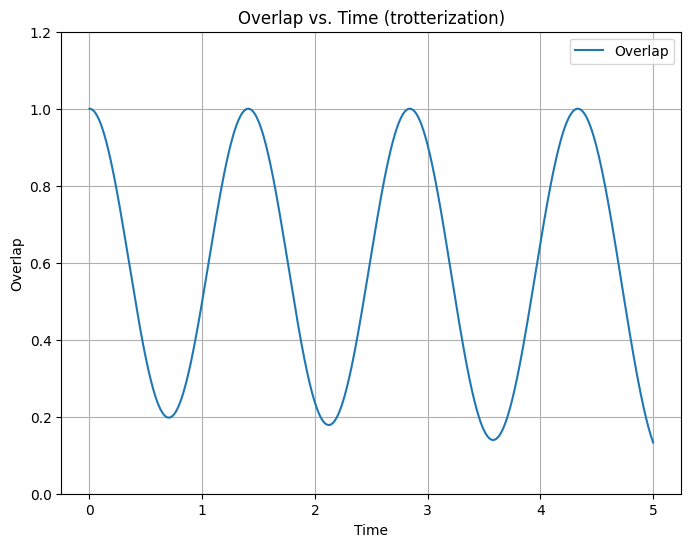

Final overlap: 0.13310936854422836


In [15]:
overlaps = []

# Compute the overlap with initial state
for t in times:
    result = paper_evo(t, n_trotter_steps)
    # result = result.numpy()  # uncomment when using pennylane_evo

    overlap = np.vdot(initial_state, result)
    overlap = np.abs(overlap)**2
    overlaps.append(overlap)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (trotterization)")
plt.grid()
plt.legend()
plt.show()

print("Final overlap:", overlaps[-1])



### Exact Evolution

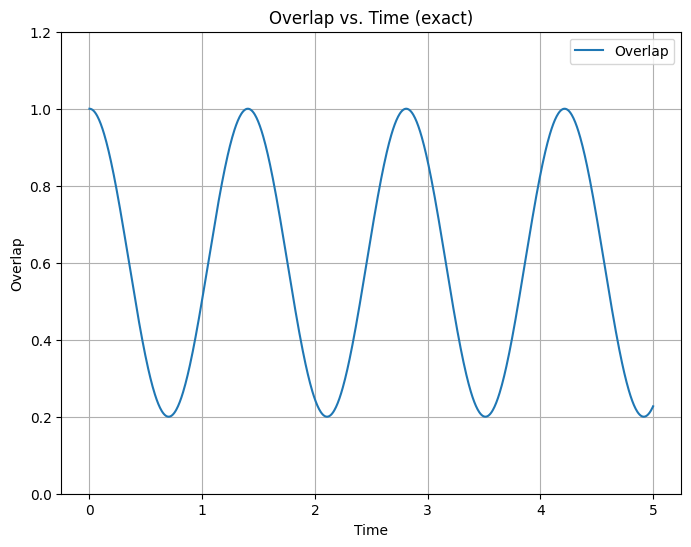

In [16]:

overlaps = []

# Compute the overlap with initial state
for t in times:
    result = exact_evo(t)  
    #result = result.numpy()  # Convert to NumPy array if required
    
    overlap = np.vdot(initial_state, result) 
    overlap = np.abs(overlap)**2
    overlaps.append(overlap)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()

### Error

In [17]:
probabilities = []

# compute overlap between exact and paper evolution
for t in times:
    evolved_state_exact = exact_evo(t)
    evolved_state_trotter = paper_evo(t, n_trotter_steps)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo
    
    overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    probability = np.abs(overlap)**2
    probabilities.append(probability)

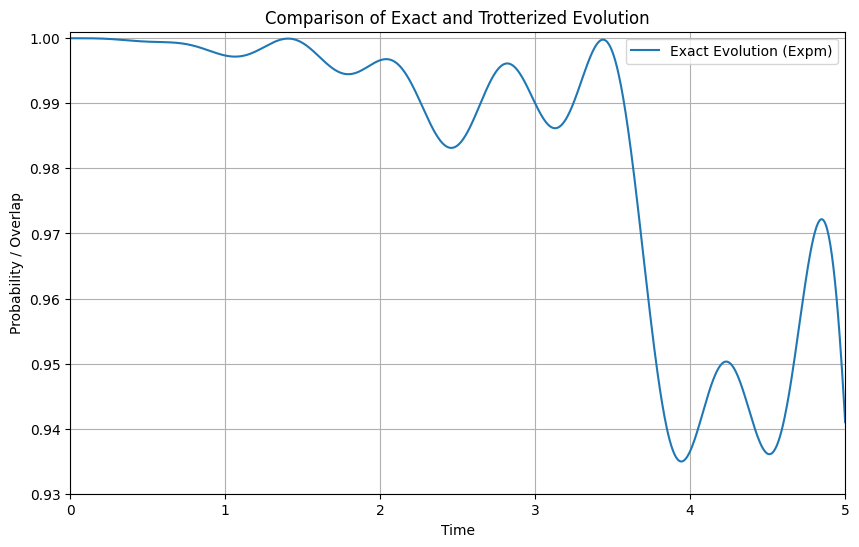

In [18]:
# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(times, probabilities, label="Exact Evolution (Expm)", markersize=3)
plt.xlabel("Time")
plt.ylabel("Probability / Overlap")
plt.xlim([0, t_max])
plt.ylim([0.93, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution")
plt.grid()
plt.legend()
plt.show()

### Extra

In [19]:
# dev = qml.device("default.qubit", wires=int(np.log2(H.shape[0])))
# @qml.qnode(dev)

# def pennylane_evo(t, n, v):
#     b=int(np.log2(H.shape[0]))
#     for i in range (0, b):
#         if v >= (2**(b-i-1)):
#             qml.PauliX(wires=(i))
#             v=v-2**(b-i-1)
#         # print(v)
#     qml.ApproxTimeEvolution(H_ps.hamiltonian(), t, n)
#     return qml.state()
